# TOA brightness temperature monitoring using S3 SLSTR

In this trial notebook we use S3 SLSTR radiometric measurements, extracted from L1b products as radiances at the top of the atmosphere (TOA), to monitor the fire developed near Chernobyl on 4/04/2020. Flames burnt for several days all around the area surrounding the abandoned nuclear power plant, enhancing the risk of emanating radioactive particles. <br>
Some studies demonstrated that radioactive particles can stimulate the ionization of atmospheric molecules, causing a transient increase of the air temperature due to the latent heat released into the atmosphere. Transient radiation formes at the top of the atmosphere from an integration of the emissions from the ground, lower atmosphere and clouds; this phenomenon should be visible as hot spots in the long wave thermal emission between 10 and 13 $\mu$m. <br>
In this notebook we use **S9** band of Sentinel-3 SLSTR RBT products, that is centered at 12022.50 nm, clipping a small region around the area of interest. The Sentinel-5P processing module is helpful in selecting the clip boundaries as from the CO emission it is easier to localise the fire. Moreover we used this üëâ[shapefile](https://emergency.copernicus.eu/mapping/list-of-components/EMSR435) released by _Copernicus Emergency Management Service_ on 11/04/2020, which delineates better the region burning.<br>
üëáüëáüëá<br>
**Requirements:**
- `xarray 0.15.0`
- `numpy 1.18.1`
- `scipy 1.4.1`
- `matplotlib 3.1.3`
- `seaborn 0.10.0`
- `holoviews 1.12.7`
- `tqdm 4.42.1`

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser("~"),"Trials/modules"))
import data_processing_S5P as dp5p
import data_processing_S3_slstr as dp
import holoviews as hv

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
coords = (50.0,52.0,27.0,32.0) # for S5P dataset
subcoords = (29.8,51.2,30.3,51.5) # clip on SLSTR dataset
xc, yc = (30.11972222,51.38305556) # chernobyl power plant coordinates 
xmin,ymin,xmax,ymax = subcoords
x0,y0 = ((xmin +xmax)/2,(ymin + ymax)/2) # rect centre

Let's check the CO levels all around the area using the `data_processing_S5P` module. We chose the date 6/04/2020 when emissions seem very high.

:Overlay
   .Scatter.I  :Scatter   [lon]   (lat,CO)
   .Scatter.II :Scatter   [x]   (y)
   .Box.I      :Box   [x,y]
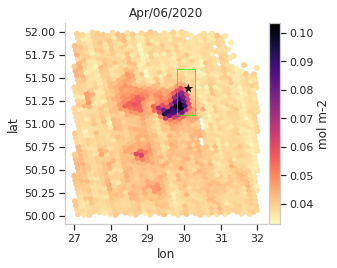

In [3]:
tropomi_ds = dp5p.read(coords,"tropomi_remote.txt") # read S5P data set and clip using the relative bounds  
im = dp5p.plot(tropomi_ds,"CO","tropomi_remote.txt")
star = hv.Scatter((xc,yc)).opts(color='k', marker='*', s=100) # chernobyl power plant
box = hv.Box(x0, y0, 0.5).opts(color='lime',lw=0.7) # SLSTR bounds 
im[0]*star*box 

### Read and clip the data set 
- Read SLSTR products using ENS: we chose days 4-5-6-11/04 2020; the first 3 days are taken during the fire, while the latter day is chosen in accordance with the publication date of the shapefile.
- Clip the data sets using bounds defined by `subcoords` and interpolate clipped data with a cubic spline to smooth the map.

In [3]:
geometry,bands = dp.open_files("slstr_remote.txt") # read SLSTR products using ENS 
ds = dp.datasets(geometry,bands) # clip the data sets over the green rectangle above
M = dp.distribution(subcoords,ds)  
xmesh,ymesh,di = dp.interp_map(M,subcoords) # maps creation 

### The approach to detect temperature anomalies
In order to detect small changes in the TOA temperature we created a mask using pixel-by-pixel median values computed on images sensed a few days before the fire, on the same geographical area, as shown in the following figure.<br>
<img src="../../media/slstr_approach_scheme.PNG" alt="drawing" width="300"/>
<br>
Then we applied this filter to fire maps by computing an element-wise difference between them, so that temperature anomalies may be enhanced.

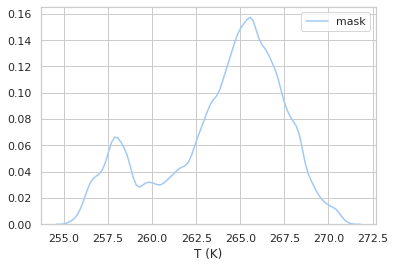

In [4]:
mask,maps = dp.apply_diff(xmesh,ymesh,di,subcoords,file="slstr_mask.txt",plot=True) # create the mask and the difference maps

## Results
Maps show that fires triggered an increase in the air temperature upon the entire area which was colder on average before that flames have developed. During the days of fire TOA temperatures are higher, showing a few hot spots up to $\sim$ 20 K difference in the regions near Chernobyl - ‚≠ê

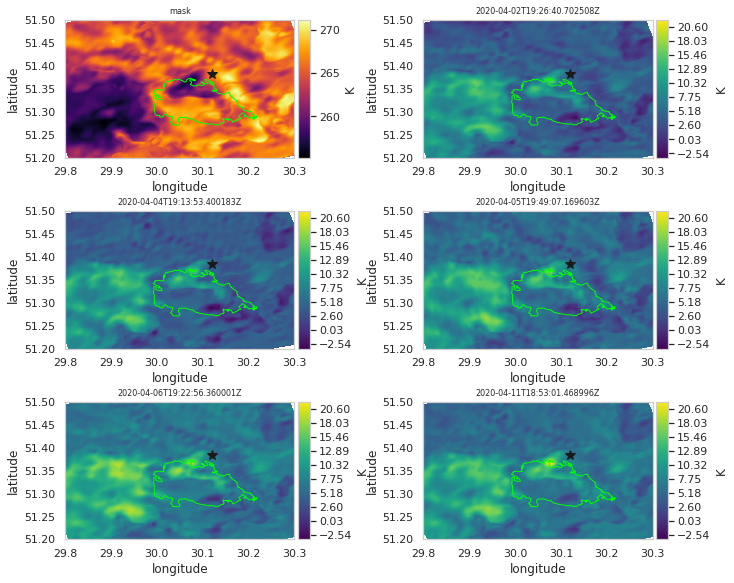

In [5]:
dp.plot_map(xmesh,ymesh,mask,maps,ds,(xc,yc))

### üìë References
- _Atmospheric Response to Fukushima Daiichi NPP (Japan) Accident Reviled by Satellite and Ground observations_, Ouzounov, D.; Pulinets, S.; Hattori, K.; Kafatos, M.; Taylor, P. [arXiv:1107.0930](https://ui.adsabs.harvard.edu/abs/2011arXiv1107.0930O/abstract); 2011
- _Remote sensing applications for diagnostics of the radioactive pollution of the ground surface and in the atmosphere_, Pulinets, Sergey; Ouzounov, Dimitar; Boyarchuk, Kirill; Laverov, Nikolay [EGU2013-12303](https://ui.adsabs.harvard.edu/abs/2013EGUGA..1512303P); 2013.
- [Sentinel-3 SLSTR Introduction - ESA Sentinel Online](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr)